# Does model width influence barcode geometry?

November 24, 2025

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from imports import *
datadir, dirname, device, device0 = init_vars('simcloud', GPU=1)

2025 November 24: ifernand running on sc
Device assigned: cuda:1
Loaded additional packages:
  scd spu readout_fit BC 
Datadir: /data/Antolik/
Dirname: /home/ifernand/


## Load Data

In [2]:
start    = time()
data     = scd.SimCloudData(down_sample=3, num_lags=11)
end      = time()

print('CPU Time', end-start, 'sec')

CPU Time 57.44639730453491 sec


In [3]:
start     = time()
test_data = scd.SimCloudData(filename='cloud_TEST_data_stim_dim120_spike_time_sqrad_0.3.hdf5', down_sample=3, num_lags=11, test=True)
end       = time()

print('CPU Time', end-start, 'sec')

CPU Time 16.762900590896606 sec


In [4]:
test_robs = test_data.repeat_robs
test_dfs = test_data.repeat_dfs
print(test_robs.shape)
print(test_dfs.shape)

(30000, 10, 1491)
(30000, 10, 1491)


In [5]:
# Load baseline LL
GLM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.npy')
GQM_LL = np.load('data/2-28_update_cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.npy')

# Load baseline LL
GLM_R2 = np.load('data/cloud_test_data_stim_dim_120_sqrad_0.3_GLM_R2.npy')
GQM_R2 = np.load('data/cloud_test_data_stim_dim_120_sqrad_0.3_GQM_R2.npy')

In [6]:
# Load Complexity Index (calculated from GQM)
comp = np.load('data/2-28_update_all_neuron_complexity_sqrad_0.3.npy')

In [7]:
cell_idx_dict = data.cell_idx_dict
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))

L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']

In [8]:
mu0s = data.mu0s
num_lags = data.num_lags
L  = data.stim_dims[1]
NC = data.NC
NT = data.NT
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

num_lags = 11
L = 40
Number of cells 1491
Number of time points 480000


In [9]:
# cell key
cell_key = data.cell_key

# integer cell key
int_key = np.zeros(NC)
int_key[L4_exc_idx] = 1
int_key[L4_inh_idx] = 2
int_key[L23_exc_idx] = 3
int_key[L23_inh_idx] = 4

# cell key dict
key_dict = {}
key_dict['L4 Exc'] = 1
key_dict['L4 Inh'] = 2
key_dict['L2/3 Exc'] = 3
key_dict['L2/3 Inh'] = 4

colors = ['tab:blue', 'tab:cyan', 'tab:red', 'm']

In [10]:
angles = np.arange(0, 180, 30).astype(int)
angles

array([  0,  30,  60,  90, 120, 150])

## Layer 4 Model for LGN Units

In [11]:
LGN_cnn = NDN.load_model('models/1016_three_layer_model_ORICONV_CNN_L4_None_maxreg.ndn')
LGN_cnn.block_sample = True
LGN_cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 12])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([300, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 794])
      bias: torch.Size([794])
      mu: torch.Size([794, 2])
      sigma: torch.Size([794, 1])
      Qmu: torch.Size([794, 1])
      Qsigma: torch.Size([794, 1])


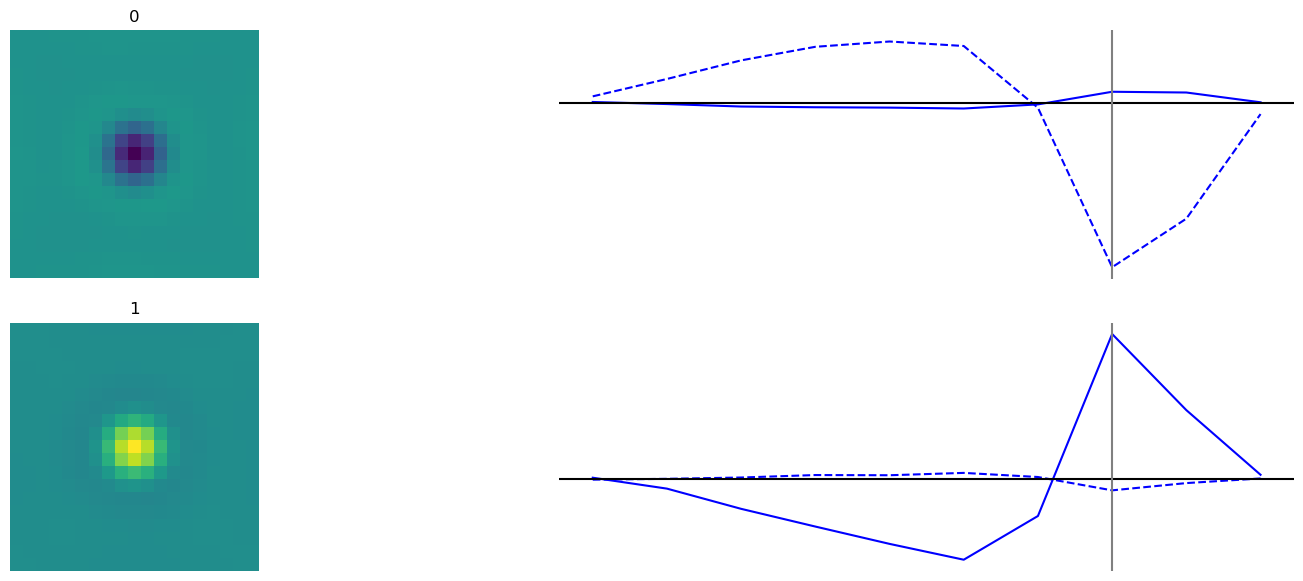

In [12]:
LGN_cnn.plot_filters()

In [13]:
LGN_filt = deepcopy(LGN_cnn.networks[0].layers[0].weight.data).reshape(LGN_cnn.networks[0].layers[0].filter_dims+[2])
LGN_filt.shape

torch.Size([1, 19, 19, 10, 2])

In [14]:
x = 5
LGN_filt_crop = LGN_filt[:,x:-x, x:-x,:,:]
LGN_filt_crop.shape

torch.Size([1, 9, 9, 10, 2])

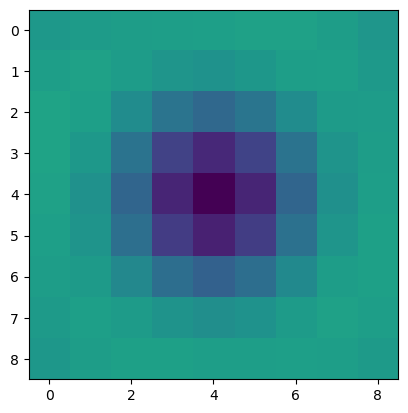

In [15]:
imagesc(LGN_filt_crop[0,:,:,-2,0].numpy(),balanced=True)

In [16]:
LGN_filt_crop = LGN_filt_crop.reshape([9*9*10,2])
LGN_filt_crop.shape

torch.Size([810, 2])

## Base Model - Over Width

In [21]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=1,
    learning_rate=0.001, early_stopping_patience=10, max_epochs=200,
    optimize_graph=False, weight_decay=0.01, accumulate_grad_batches=5)
adam_pars['device'] = device

In [25]:
#=====From Scratch Model=====
Treg0 = 0.0001
Xreg0 = 1.0 # d2/dx
Creg0 = 0.05 # center

Xreg1 = 0.003 # d2/dx
Creg1 = 1e-11 # center

MaxReg = 0.001

NQ = len(angles)

fws = [9, 19, 1, 1]
nsubs_list = [[2,8,8,8], [2,16,8,8], [2,32,8,8], [2,40,8,8],
              [2,16,12,12], [2,32,12,12], [2,40,12,12],
              [2,32,20,20], [2,40,20,20], [2,40,32,32]]

N_models = len(nsubs_list)
   
cnn_list = []
for jj in range(N_models):
    num_subs = nsubs_list[jj]
    # LGN LAYER
    clayersQ = [STconvLayer.layer_dict( 
        input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
        filter_dims=[1,fws[0],fws[0],num_lags-1] , bias=False, NLtype='relu',
        padding='same', output_norm='batch', window='hamming', initialize_center=True,
        reg_vals={'d2t':Treg0, 'd2x':Xreg0, 'center': Creg0} )]

    # PROJECTION LAYER
    clayersQ.append(
        OriConvLayer.layer_dict(
            num_filters=num_subs[1], num_inh=num_subs[1]//2,
            filter_width=fws[1], NLtype='relu', norm_type=1,
            bias=False, output_norm='batch', window='hamming', padding='same', initialize_center=True, 
            reg_vals={'d2x':Xreg1, 'center': Creg1}, angles=angles) )

    # TIME SHIFT LAYER
    clayersQ.append(TimeShiftLayer.layer_dict())

    # REST
    for ii in range(2,len(fws)):
        clayersQ.append(OriConvLayer.layer_dict( 
            num_filters=num_subs[ii], num_inh=num_subs[ii]//2, 
            bias=False, norm_type=1, filter_width=fws[ii], NLtype='relu',
            output_norm='batch', initialize_center=True,
            angles=angles) )
        
    scaffold_netQ =  FFnetwork.ffnet_dict(
        ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,3,4], num_lags_out=NQ)

    readout_parsQ = ReadoutLayerQsample.layer_dict(
        num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
        reg_vals={'max': MaxReg})

    readout_netQ = FFnetwork.ffnet_dict(xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

    cnn = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poisson', seed=100)
    # Network 0: fix LGN filters
    cnn.networks[0].layers[0].weight.data = LGN_filt_crop
    cnn.networks[0].layers[0].set_parameters(val=False)
    # Network 1: set mu values
    cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
    cnn.networks[1].layers[0].fit_mus(False)
    cnn.networks[1].layers[0].sample_mode = 'nearest'
    cnn.networks[1].layers[0].degrees2mu(V1_thetas, continuous=False)
    cnn.networks[1].layers[0].fit_Qmus(False)
    cnn.networks[1].layers[0].Qsample_mode = 'nearest'
    cnn.block_sample = True
    cnn.loss_module.unit_weighting = True
    cnn_list.append(cnn)

  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus
  ReadoutLayer: not fitting mus
  ReadoutLayer: not fitting Qmus


In [ ]:
R2_list = np.zeros((N_models,NC))
for i in range(N_models):
    cnn = deepcopy(cnn_list[i])
    start = time()
    cnn.fit(data, **adam_pars, verbose=False)
    end = time()
    cnn.save_model('models/width_test_12-24-25/NDN491_Q5_R1_version'+str(63+i)+'_width_'+str(nsubs_list[i][1])+'-'+str(nsubs_list[i][2])+'-'+str(nsubs_list[i][3])+'.ndn')
    test_pred = cnn.predictions(test_data, data_inds=np.arange(test_data.NB), batch_size=1, num_lags=num_lags, device=device).detach().cpu().numpy()
    R2 = spu.comp_test_R2(test_robs, test_dfs, test_pred)
    R2_list[i,:] = R2
    print('MODEL', i+1)
    print('Train time:', end-start, 'sec')
    print('Mean R2:', np.mean(R2))
    print('Max R2:', np.max(R2))
    print(' ')

  Model saved:  models/width_test_12-24-25/NDN491_Q5_R1_version63_width_8-8-8.ndn


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 16.19it/s]


MODEL 1
Train time: 21625.00238084793 sec
Mean R2: 0.2159367052254496
Max R2: 0.6345935624987084
 


In [ ]:
print('DONE')